# scRNA-seq: B lymphocytes treated with a novel IL-10 inducer

## --- Annotation ---

## Table of contents:

  * <a href=#Reading>1 Reading in the data</a>
  * <a href=#Preprocessing>2 Pre-processing and visualization</a>
    * <a href=#QC>2.1 Quality Control</a>

# 0. Loading the libraries

[Timing: 50s]

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sb
import joypy

import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [2]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.1.0
anndata2ri                  1.0.6
appdirs                     1.4.4
asttokens                   NA
attr                        21.4.0
backcall                    0.2.0
backports                   NA
beta_ufunc                  NA
binom_ufunc                 NA
bioinfokit                  2.0.8
bioservices                 1.8.4
boto3                       1.23.1
botocore                    1.26.1
brotli                      1.0.9
bs4                         4.11.1
cattr                       NA
certifi                     2021.10.08
cffi                        1.15.0
charset_normalizer          2.0.12
cloudpickle                 2.0.0
colorama                    0.4.4
colorlog                    NA
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.11.2
dask                        2022.05.0
dateutil                    2.8.2
debugpy                     1.6.0
deco

In [4]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 108))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,35))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

<a id="Reading"></a>

# 1. Reading in the data

[Timing: 35s reading from cache]

In [5]:
# Load the pre-processed data

with open('saved_objects/adata_annotated.pkl', 'rb') as inp: #preprocessed
    adata = pickle.load(inp)

In [7]:
save_folder = "figures/"
sc.settings.figdir = './'+save_folder

## 3 Annotation

## 3.1 Il-10 expression

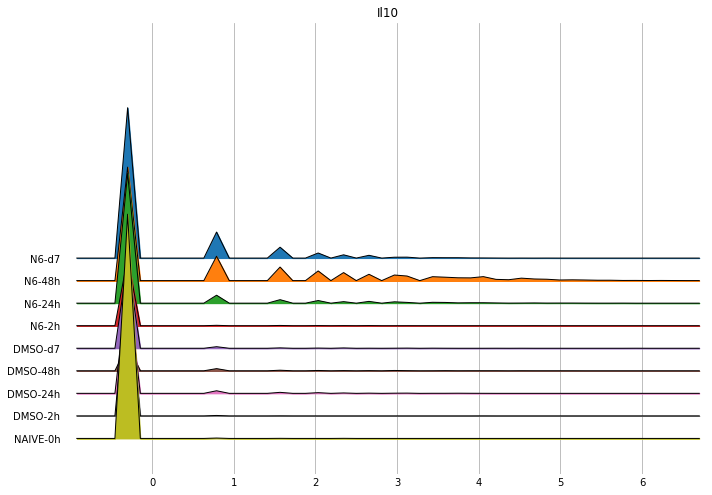

In [8]:
marker = "Il10"

conditions = ["N6-d7", "N6-48h", "N6-24h", "N6-2h", "DMSO-d7", "DMSO-48h", "DMSO-24h", "DMSO-2h", "NAIVE-0h"]
mycolors = plt.rcParams["axes.prop_cycle"].by_key()['color']

data_ridge = pd.DataFrame()
data_ridge[marker] = np.array(adata.X[:, adata.var.index == marker])[:,0]
data_ridge['condi'] = np.array(adata.obs['sample2'])
data_ridge['condi'] = pd.Categorical(data_ridge['condi'], 
                      categories=conditions,
                      ordered=True)

%matplotlib inline
fig, axes = joypy.joyplot(data_ridge, column=marker, by="condi", 
                            kind="counts", bins=50, overlap=5, x_range=[-1,max(data_ridge[marker])],
                            grid="x", legend=False, figsize=(10,7), linewidth=1,
                            color=mycolors, title = marker)

fig.savefig(save_folder+"ridge_"+marker+".png")
plt.rcParams['figure.figsize']=(8,8) #rescale figures

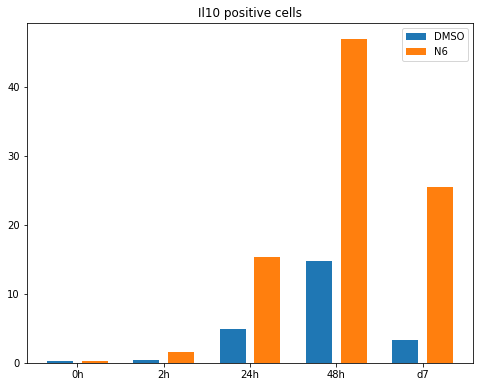

In [9]:
plt.title(marker+' positive cells')

marker_data = pd.DataFrame()
conditions1 = ["NAIVE-0h", "DMSO-2h", "DMSO-24h", "DMSO-48h", "DMSO-d7"]
marker_data["x"] = conditions1
marker_data["y"] = [sum(data_ridge[data_ridge['condi'] == cond][marker] > 0) / len(data_ridge[data_ridge['condi'] == cond][marker]) for cond in conditions1]
marker_data["y"] = marker_data["y"]*100

pos = (0,10,20,30,40)
plt.bar(pos, marker_data["y"], width = 3, label='DMSO')

marker_data = pd.DataFrame()
conditions2 = ["NAIVE-0h", "N6-2h", "N6-24h", "N6-48h", "N6-d7"]
marker_data["x"] = conditions2
marker_data["y"] = [sum(data_ridge[data_ridge['condi'] == cond][marker] > 0) / len(data_ridge[data_ridge['condi'] == cond][marker]) for cond in conditions2]
marker_data["y"] = marker_data["y"]*100

pos = (4,14,24,34,44)
plt.bar(pos, marker_data["y"], width = 3, label='N6')

posx = (2,12,22,32,42)
plt.xticks(posx, ["0h", "2h", "24h", "48h", "d7"])
plt.subplots_adjust(bottom=0.4, top=0.99)
plt.legend()
plt.grid(visible=False)

plt.savefig(save_folder+marker+"_positive_cells.png")
plt.show()


In [10]:
#Define a variable that stores marker positivity
adata.obs[marker+'_positive'] = [marker+'+' if val>0 else marker+'-' for val in data_ridge[marker]]

adata.obs[marker+'_low'] = ['Low' if 0<val<1 else 'Not' for val in data_ridge[marker]]
adata.obs[marker+'_high'] = ['High' if val>3 else 'Not' for val in data_ridge[marker]]
adata.obs[marker+'_highlow'] = (adata.obs[marker+'_high']=='High') | (adata.obs[marker+'_low']=='Low')

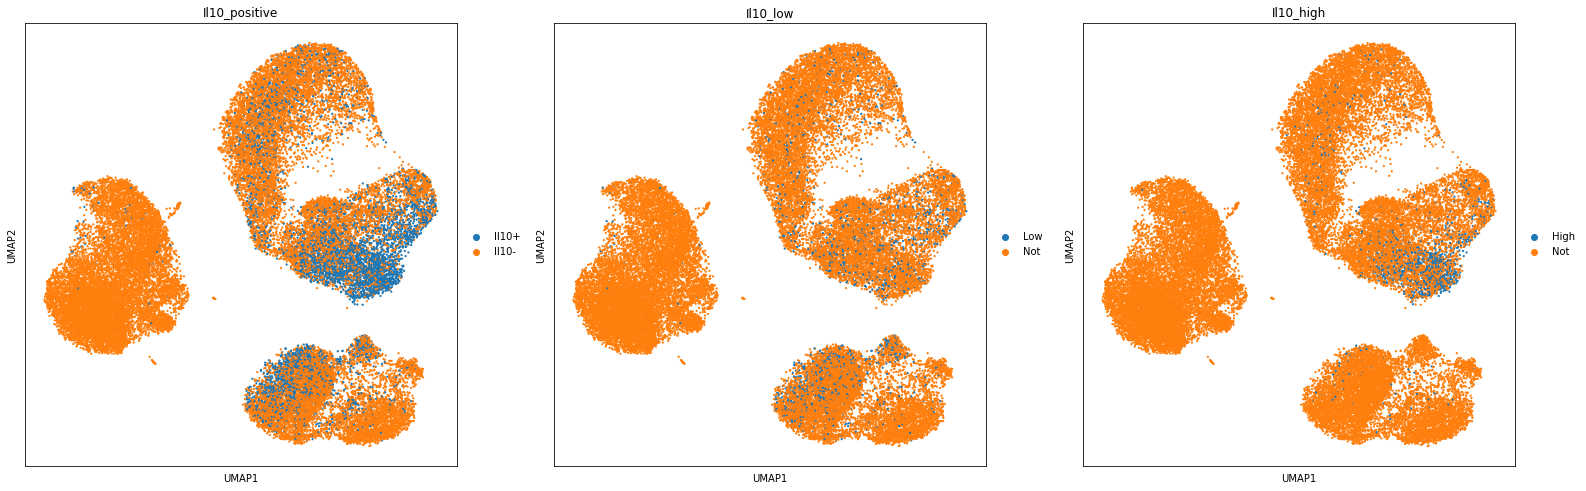

In [11]:
# Represent marker cells on the UMAP
s = 20
sc.pl.umap(adata, color=[marker+'_positive', marker+'_low', marker+'_high'], size = s, save=marker+'pos_cells.png')

computing density on 'umap'
--> added
    'umap_density_Il10_positive', densities (adata.obs)
    'umap_density_Il10_positive_params', parameter (adata.uns)
computing density on 'umap'
--> added
    'umap_density_Il10_high', densities (adata.obs)
    'umap_density_Il10_high_params', parameter (adata.uns)


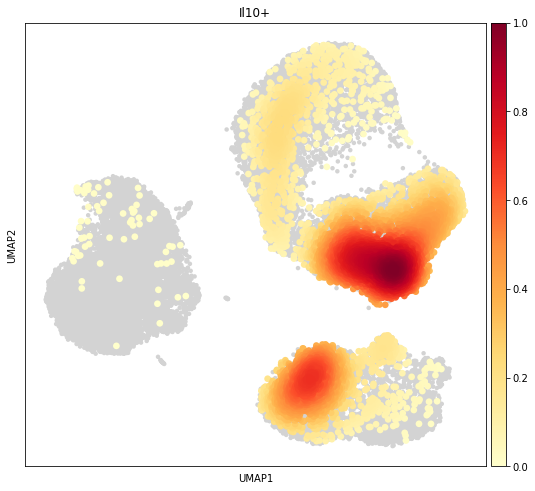

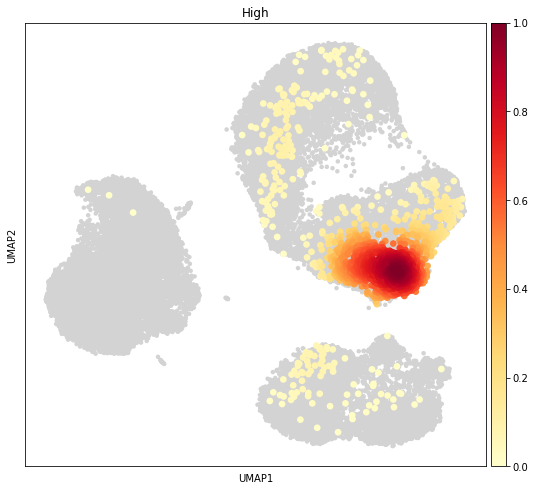

In [12]:
#Compute density on UMAP
sc.tl.embedding_density(adata, basis='umap', groupby=marker+'_positive')
sc.tl.embedding_density(adata, basis='umap', groupby=marker+'_high')

sc.pl.embedding_density(adata, basis='umap', key='umap_density_'+marker+'_positive', group=marker+'+', save=marker+"pos_cells_post.png")
sc.pl.embedding_density(adata, basis='umap', key='umap_density_'+marker+'_high', group='High', save=marker+"hi_cells_post.png")

In [ ]:
save_object(adata, 'saved_objects/adata_annotated.pkl')

## 3.2 Clustering 2 hours

In [6]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures

In [7]:
adata_2h = adata[adata.obs['tp'] == "2h"].copy()

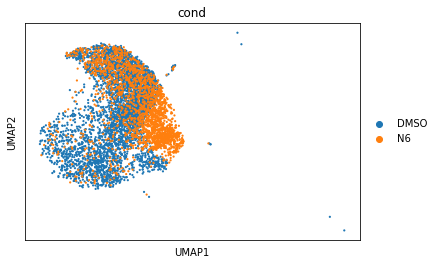

In [8]:
sc.pl.umap(adata_2h, color = 'cond')

In [9]:
sc.tl.leiden(adata_2h, resolution=0.4, random_state = 0) #0.4

running Leiden clustering
    finished: found 51 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


In [10]:
idx = adata_2h.obs['leiden'].value_counts()[adata_2h.obs['leiden'].value_counts() > 50].index.tolist()
view = adata_2h[adata_2h.obs['leiden'].isin(idx)]

In [11]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 108))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,5))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

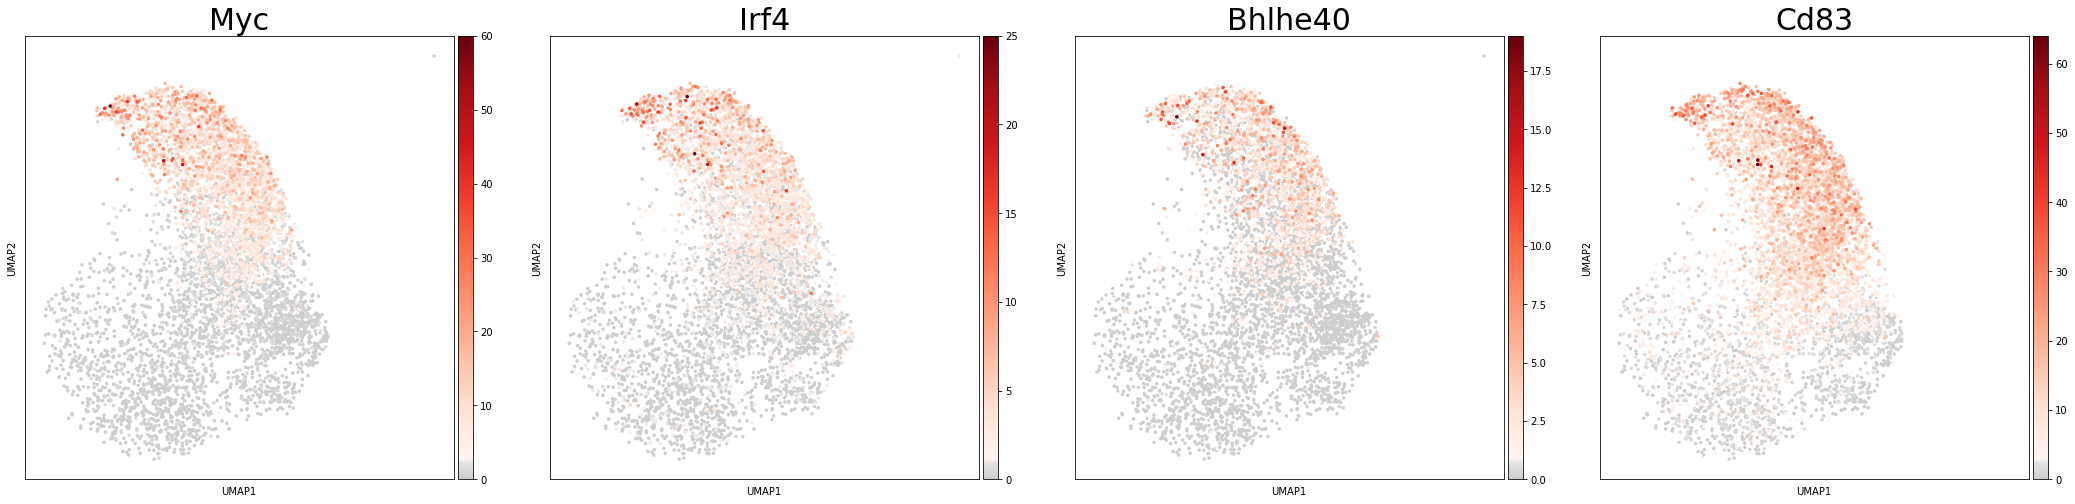

In [12]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
plt.rcParams.update({'axes.titlesize' : 30}) 
sc.pl.umap(view, cmap=mymap, color = ['Myc', 'Irf4', 'Bhlhe40', 'Cd83'], size = 50, save="_cpg_signature.png")

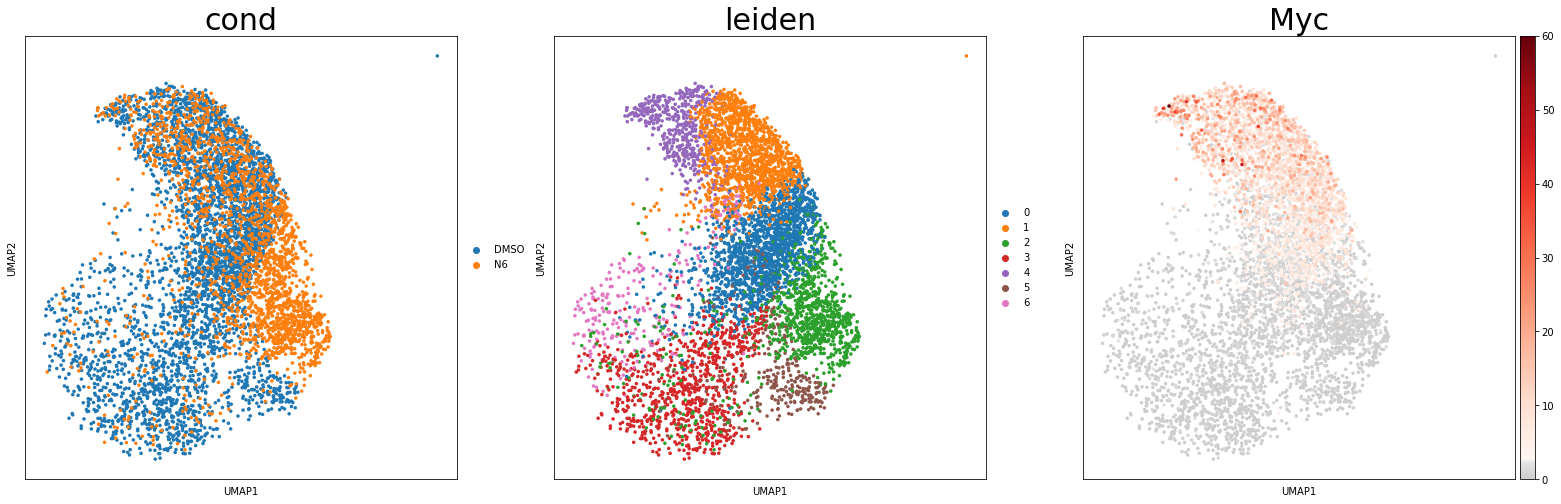

In [13]:
sc.pl.umap(view, cmap=mymap, color = ['cond', 'leiden', 'Myc'], size = 50)

In [14]:
from pandas.api.types import CategoricalDtype
obs_save = view.obs
dictio = {
    "0": 'N6-independent_2h', 
    "1": 'N6-independent_2h', 
    "2": 'N6-dependent_2h', 
    "3": 'Naïve-like_2h', 
    "4": 'N6-independent_2h',
    "5": 'Naïve-like_2h',
    "6": 'Naïve-like_2h'
    }
cat_type = CategoricalDtype(categories=
    ['Naïve-like_2h', 'N6-dependent_2h', 'N6-independent_2h']
    ,ordered=True)
new_obs = obs_save['leiden'].map(dictio).astype(cat_type)
view.obs['clusters'] = new_obs

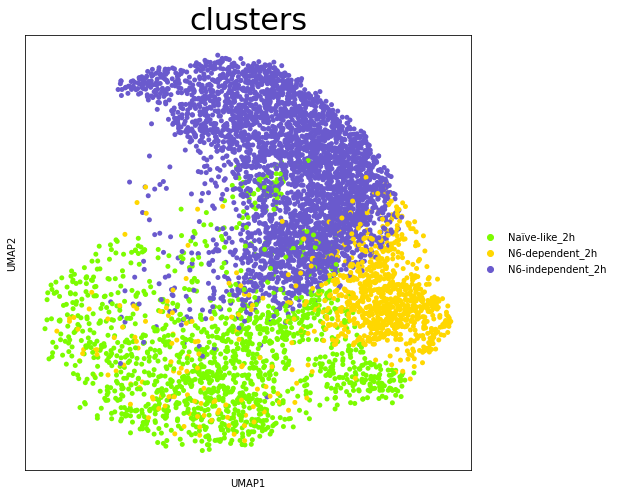

In [15]:
sc.pl.umap(view[view.obsm["X_umap"][:,0]<3], color = ['clusters'], size = 100, save = "_2h_clustering.pdf", add_outline = False,
            palette = {
            "N6-independent_2h" : "slateblue", 
            "N6" : "tab:orange", 
            "N6-dependent_2h" : "gold", 
            "DMSO" : "tab:green", 
            "Naïve-like_2h" : "lawngreen"})

In [25]:
view.X = view.raw.X
sc.pp.log1p(view)

In [26]:
sc.tl.rank_genes_groups(view, use_raw = False, groupby='clusters')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


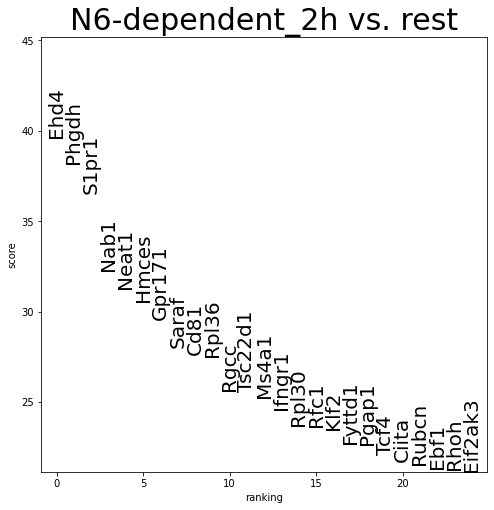

In [27]:
sc.pl.rank_genes_groups(view, fontsize = 20, n_genes=25, ncols=1, groups = ['N6-dependent_2h'])

In [49]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

sv = sc.pl.rank_genes_groups_stacked_violin(view, fontsize = 20, n_genes=9, ncols=1, groups = ['N6-dependent'],
        swap_axes=False, dendrogram=False, figsize=(6, 3), width=0.8, row_palette=['lawngreen', 'gold', 'slateblue'], return_fig=True)

plt.setp(sv.get_axes()['mainplot_ax'].xaxis.get_majorticklabels(), rotation=40, va="center", position=(0,-0.09))
plt.savefig("figures/violin_n6-2h.png", bbox_inches='tight', dpi = 1000)

KeyError: "None of [Index(['N6-dependent'], dtype='object')] are in the [columns]"

In [38]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 35))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,10))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

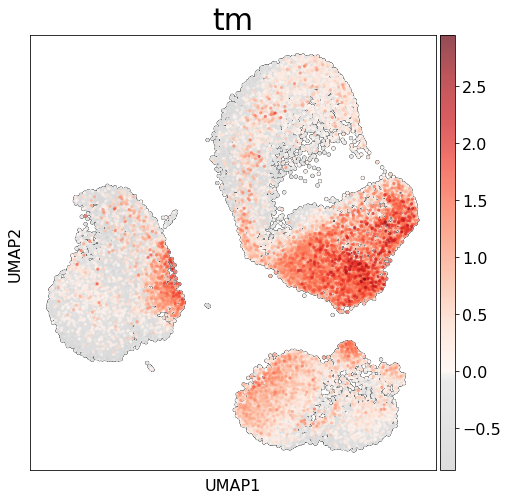

In [39]:
list_markers = ["Ehd4", "Phgdh", "S1pr1", "Nab1", "Hmces", "Cd81", "Saraf", "Neat1", "Gpr171"]
df = pd.DataFrame(columns=list_markers, index=adata.obs.index)
for mark in list_markers:
    df[mark] = adata.X[:, adata.var['gene_name'] == mark]
adata.obs["tm"] = df.mean(axis=1)

sc.pl.umap(adata, cmap = mymap, color = "tm", size = 40, add_outline = True, outline_width = [0.1, 0.05],
        ncols = 2, save = "_N6resp.png")

In [ ]:
adata.obs['clusters_2h'] = view.obs['clusters']

## 3.3 Clustering 24 hours

In [174]:
adata_24h = adata[adata.obs['tp'] == "24h"].copy()

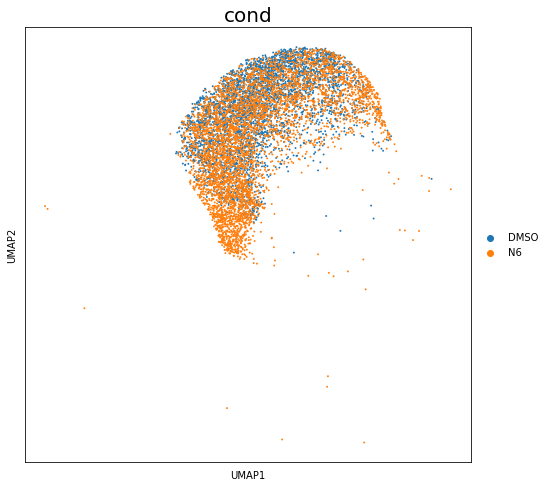

In [175]:
sc.pl.umap(adata_24h, color = 'cond')

In [176]:
sc.tl.leiden(adata_24h, resolution=1, random_state = 0)

running Leiden clustering
    finished: found 22 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


In [177]:
idx = adata_24h.obs['leiden'].value_counts()[adata_24h.obs['leiden'].value_counts() > 50].index.tolist()
view = adata_24h[(adata_24h.obs['leiden'].isin(idx)) & (adata_24h.obsm['X_umap'][:,1]>2) & (adata_24h.obsm['X_umap'][:,0]>2)]

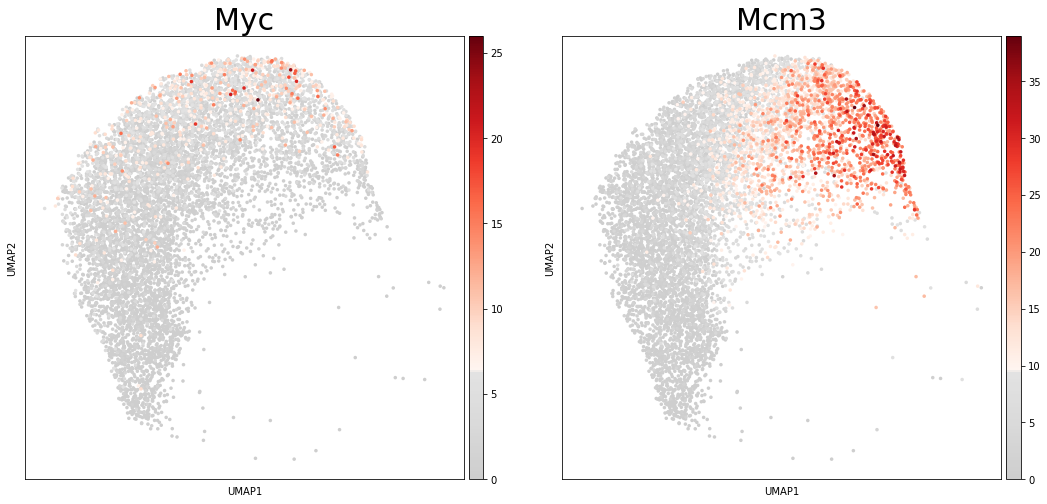

In [178]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
plt.rcParams.update({'axes.titlesize' : 30})
sc.pl.umap(view, cmap=mymap, color = ['Myc', 'Mcm3'], size = 50, save="_24h_cc.png")

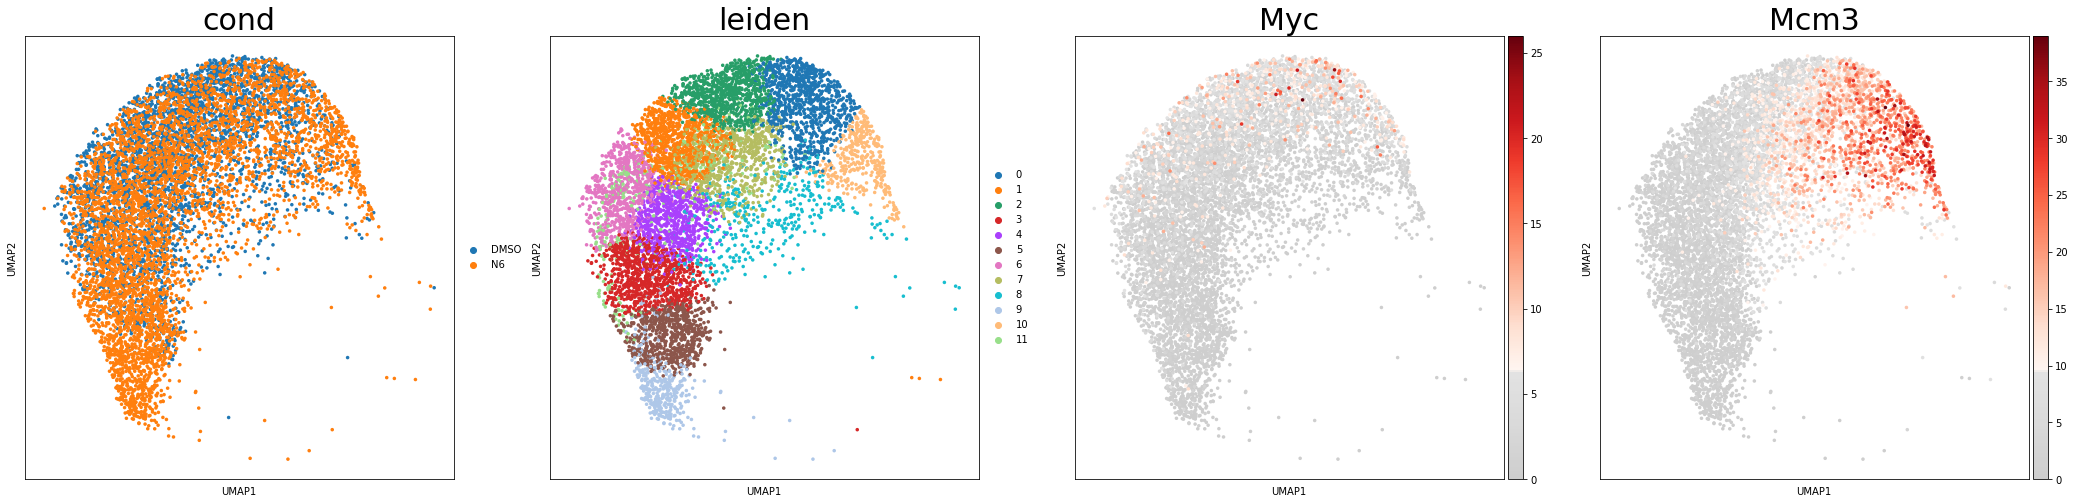

In [179]:
sc.pl.umap(view, cmap=mymap, color = ['cond', 'leiden', 'Myc', 'Mcm3'], size = 50)

In [180]:
from pandas.api.types import CategoricalDtype
obs_save = view.obs
dictio = {
    "0": 'CC', "1": 'CC', "2": 'CC', "3": 'CC', "4": 'CC',
    "5": 'noCC-mixed',
    "6": 'CC', "7": 'CC', "8": 'CC',
    "9": 'noCC-N6',
    "10": 'CC', "11": 'CC'
    }
cat_type = CategoricalDtype(categories=
    ['CC', 'noCC-mixed', 'noCC-N6']
    ,ordered=True)
new_obs = obs_save['leiden'].map(dictio).astype(cat_type)
view.obs['clusters'] = new_obs

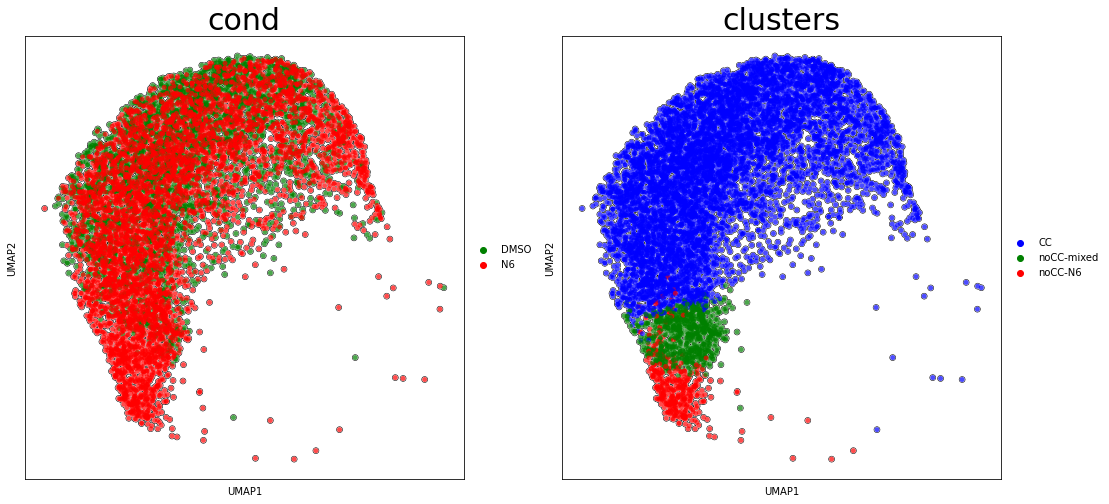

In [183]:
sc.pl.umap(view, color = ['cond', 'clusters'], size = 100, save = "_24h_clustering.png", add_outline = True, outline_width = [0.1, 0.05],
            palette = {"CC" : "blue", "N6" : "red", "noCC-N6" : "red", "DMSO" : "green", "noCC-mixed" : "green"})

In [ ]:
sc.tl.rank_genes_groups(view, groupby='clusters')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


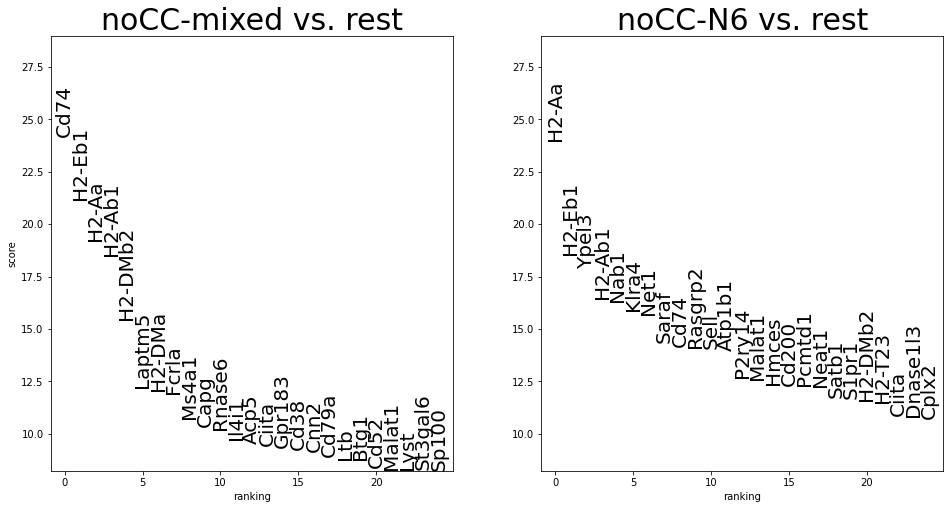

In [ ]:
sc.pl.rank_genes_groups(view, fontsize = 20, n_genes=25, ncols=2, groups = ['noCC-mixed', 'noCC-N6'])

In [ ]:
adata.obs['clusters_24h'] = view.obs['clusters']

## 3.3 Day 7 clustering

In [ ]:
adata_d7 = adata[adata.obs['tp'] == "d7"].copy()

In [ ]:
sc.tl.leiden(adata_d7, resolution=0.3, random_state=0)

running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


In [ ]:
idx = adata_d7.obs['leiden'].value_counts()[adata_d7.obs['leiden'].value_counts() > 50].index.tolist()
view = adata_d7[(adata_d7.obs['leiden'].isin(idx)) & (adata_d7.obsm['X_umap'][:,1] < 0)]

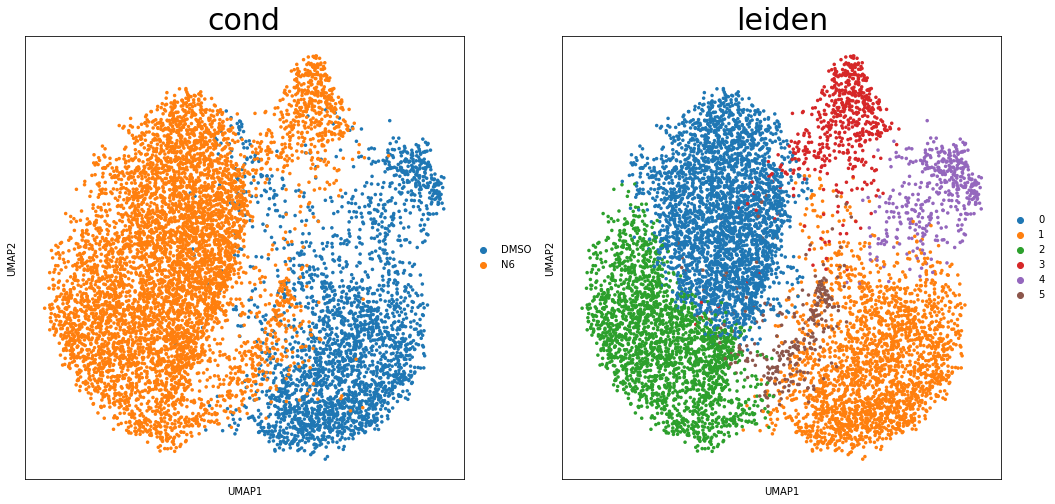

In [ ]:
sc.pl.umap(view, color = ['cond', 'leiden'], size = 50)

In [ ]:
from pandas.api.types import CategoricalDtype
obs_save = view.obs
dictio = {
    "0": 'N6', 
    "1": 'DMSO', 
    "2": 'N6', 
    "3": 'N6-Ki67', 
    "4": 'DMSO-Ki67',
    "5": 'N6-Irf4n'
    }
cat_type = CategoricalDtype(categories=
    ['N6', 'N6-Ki67', 'N6-Irf4n', 'DMSO', 'DMSO-Ki67']
    ,ordered=True)
new_obs = obs_save['leiden'].map(dictio).astype(cat_type)
view.obs['clusters'] = new_obs

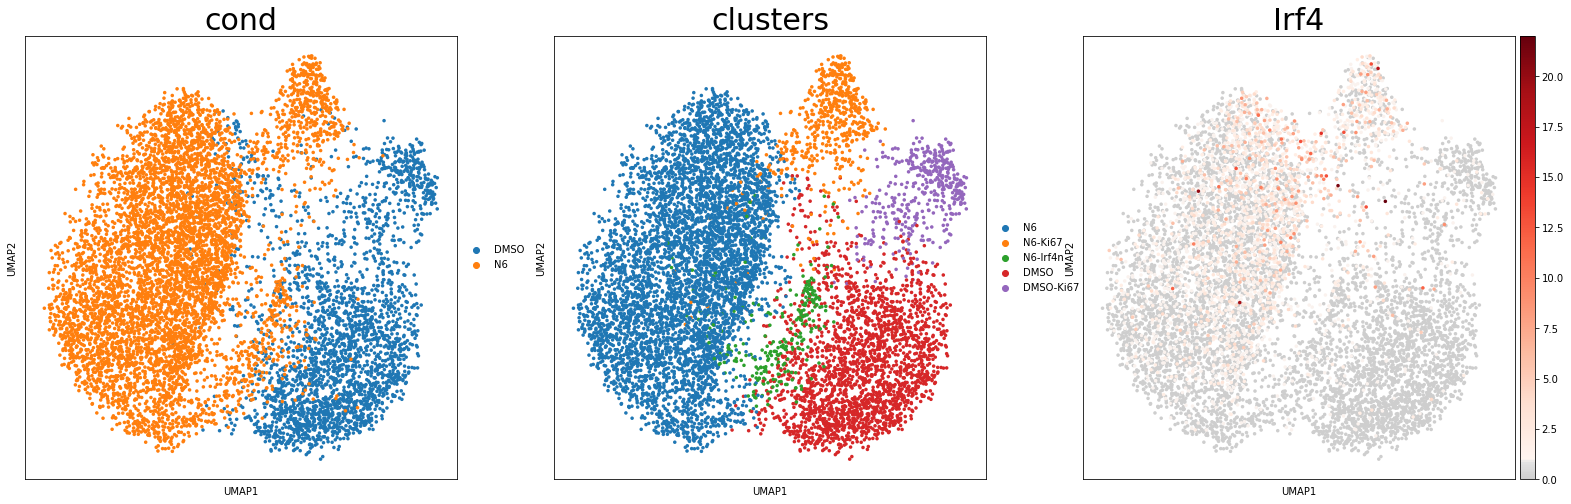

In [ ]:
sc.pl.umap(view, cmap=mymap, color = ['cond', 'clusters', 'Irf4'], size = 50, save = "_d7_clustering.png")

In [ ]:
sc.tl.rank_genes_groups(view, groupby='clusters')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


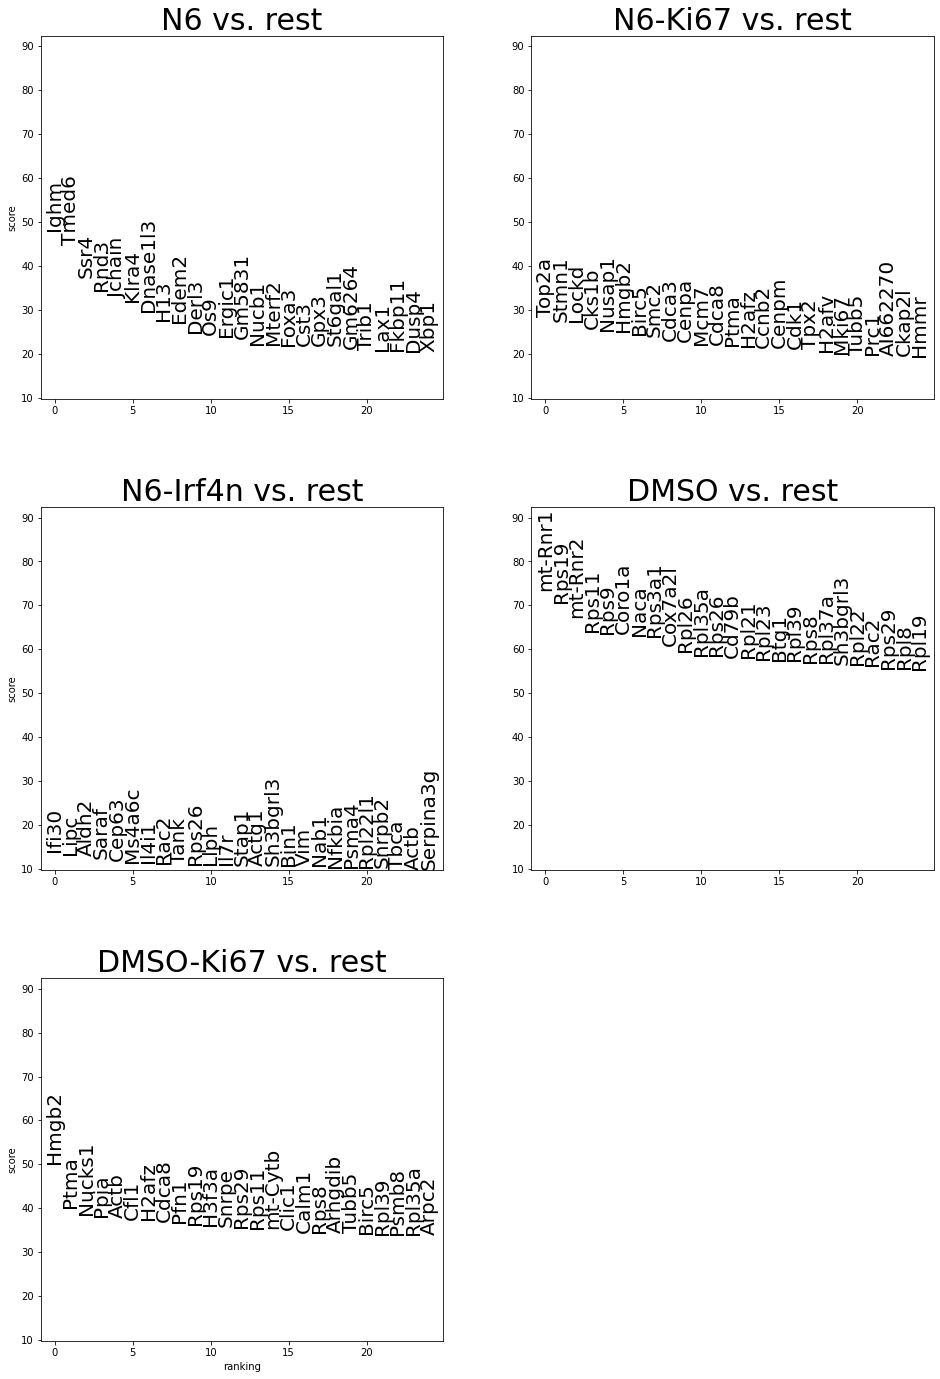

In [ ]:
sc.pl.rank_genes_groups(view, fontsize = 20, n_genes=25, ncols=2)

In [ ]:
adata.obs['clusters_d7'] = view.obs['clusters']

## 4 Save object

In [ ]:
save_object(adata, 'saved_objects/adata_annotated.pkl')